# Designing Spiking Neural Networks from scratch

Defining a class for singla neuron and another class for network.

Setting the topology of the network randomly.

Considering some specific neurons as input and output layers.

Updating the membrane voltage of each neuron based on integrate and fire method. Considering refractoriness period .

### A Class for a single Neuron

Based on LIF(Leaky-Integrate and Fire) Model.

Input currents (pre-synaptic) are supposed as impulse functions, so their effect in PDE is a 



In [61]:
class Neuron:
    def __init__(self, rest_voltage, threshold, time_constant, refractoriness_time):
        self.rest_voltage = rest_voltage
        self.voltage = rest_voltage
        self.threshold = threshold
        self.time_constant = time_constant

        self.sigma = False  # output spike
        self.input_current = 0.0

        self.refractory = False
        self.refractoriness_time = refractoriness_time
        self.refractoriness_counter = 0

    def time_and_voltage_update(self):

        if self.refractory:
            self.refractoriness_count()
            self.sigma = False
        else:
            

            if self.voltage >= self.threshold:
                self.voltage = self.rest_voltage
                self.refractory = True
                self.refractoriness_counter = 0
                self.sigma = True
            else:
                self.sigma = False

            dV = - self.voltage / self.time_constant  # decay part
            self.voltage += dV
            self.voltage += self.input_current # Step change part - Delta Input Current 

        # reset input after each timestep
        self.input_current = 0.0

    def refractoriness_count(self):
        self.refractoriness_counter += 1
        if self.refractoriness_counter >= self.refractoriness_time:
            self.refractoriness_counter = 0
            self.refractory = False


#### A Test for neuron class

In [62]:
# Instantiate neuron
neuron = Neuron(
    rest_voltage=0.0,
    threshold=2.0,
    time_constant=10.0,
    refractoriness_time=3
)

# Simulation parameters
timesteps = 30
input_current = 1.0  # strong enough to trigger spikes

print("t | V      | spike | refractory")
print("--------------------------------")

for t in range(timesteps):
    neuron.input_current = input_current
    neuron.time_and_voltage_update()

    print(
        f"{t:2d} | "
        f"{neuron.voltage:6.3f} | "
        f"{int(neuron.sigma)}     | "
        f"{neuron.refractory}"
    )


t | V      | spike | refractory
--------------------------------
 0 |  1.000 | 0     | False
 1 |  1.900 | 0     | False
 2 |  2.710 | 0     | False
 3 |  1.000 | 1     | True
 4 |  1.000 | 0     | True
 5 |  1.000 | 0     | True
 6 |  1.000 | 0     | False
 7 |  1.900 | 0     | False
 8 |  2.710 | 0     | False
 9 |  1.000 | 1     | True
10 |  1.000 | 0     | True
11 |  1.000 | 0     | True
12 |  1.000 | 0     | False
13 |  1.900 | 0     | False
14 |  2.710 | 0     | False
15 |  1.000 | 1     | True
16 |  1.000 | 0     | True
17 |  1.000 | 0     | True
18 |  1.000 | 0     | False
19 |  1.900 | 0     | False
20 |  2.710 | 0     | False
21 |  1.000 | 1     | True
22 |  1.000 | 0     | True
23 |  1.000 | 0     | True
24 |  1.000 | 0     | False
25 |  1.900 | 0     | False
26 |  2.710 | 0     | False
27 |  1.000 | 1     | True
28 |  1.000 | 0     | True
29 |  1.000 | 0     | True


### Desiging a class for Network (SNN)

Topology : a 2D array (N*N) , describing the existence of axon from j to i 

topology_init(): Init connections withh probability $p$ and with exact input connection $k$ (fixed-in degree)

enforce excitatory / inhibitory as positive/negative weights

In [63]:
import numpy as np

class SNN:
    def __init__(self, N, exc_ratio, *, in_dim, out_dim, **neuron_params):
        self.N = N
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.neurons = [
            Neuron(**neuron_params) for _ in range(N)
        ]

        self.topology = self.topology_init(N, p=0.25)
        self.interface_init()
        self.weights = np.zeros((self.N, self.N), dtype=np.int32)

        self.exc_ratio = exc_ratio # Ratio of excitory neurons to all
        self.excitatory_init(exc_ratio=self.exc_ratio)

        self.weights_init(w_exc=(1, 5),w_inh=(-5, -1)) # Initializing weights , integer ranges should be modified later.
        
    def topology_init(self, N, p, allow_self_connections=False, seed=None):
        if seed is not None:
            np.random.seed(seed)

        A = np.random.rand(N, N) < p

        if not allow_self_connections:
            np.fill_diagonal(A, False)

        return A

    def interface_init(self):
        assert self.in_dim + self.out_dim <= self.N

        indices = np.random.permutation(self.N)
        self.in_interface = indices[:self.in_dim] # Input interface indices
        self.out_interface = indices[self.in_dim:self.in_dim + self.out_dim]   # Output interface indices

    
    def excitatory_init(self, exc_ratio=0.8, seed=None):
        """
        Initialize excitatory / inhibitory neuron types.
        True  -> excitatory
        False -> inhibitory
        """
        if seed is not None:
            np.random.seed(seed)
    
        n_exc = int(exc_ratio * self.N)
    
        self.if_excitatory = np.zeros(self.N, dtype=bool)
        self.if_excitatory[:n_exc] = True
    
        # Shuffle to avoid positional bias
        np.random.shuffle(self.if_excitatory)

    def weights_init(
        self,
        w_exc=(1, 5),
        w_inh=(-5, -1),
        seed=None
    ):
        """
        Initialize integer weights using topology and neuron type.
        """
        if seed is not None:
            np.random.seed(seed)
    
        self.weights.fill(0)
        # topology[i, j] = connection from j → i
        for j in range(self.N):
            mask = self.topology[:, j]
    
            if not mask.any():
                continue
    
            if self.if_excitatory[j]:
                self.weights[mask, j] = np.random.randint(
                    w_exc[0], w_exc[1] + 1, size=mask.sum()
                )
            else:
                self.weights[mask, j] = np.random.randint(
                    w_inh[0], w_inh[1] + 1, size=mask.sum()
                )

    def feed_forward(self, input_data):
        assert len(input_data) == self.in_dim #  input dimension = network in_dim / Edit for batch dimension 
        for n in self.neurons:
            n.input_current = 0
        self.network_current_update(input_data)
        self.network_voltage_update()

    def network_current_update(self, input_data):
        for i in range(self.N):
            pres = np.where(self.topology[i])[0]
            for j in pres:
                self.neurons[i].input_current += (self.weights[i, j] *self.neurons[j].sigma)
        for k in range(self.in_dim): # accessing to input layer indices
            indice = self.in_interface[k]
            self.neurons[indice].input_current += input_data[k]

    def network_voltage_update(self):
        for n in self.neurons:
            n.time_and_voltage_update()


#### Test for SNN

In [64]:
# ---- Test SNN instantiation ----

N = 20
exc_ratio = 0.75
in_dim = 4
out_dim = 3

neuron_params = dict(
    rest_voltage=0.0,
    threshold=1.0,
    time_constant=10.0,
    refractoriness_time=3
)

net = SNN(
    N=N,
    exc_ratio=exc_ratio,
    in_dim=in_dim,
    out_dim=out_dim,
    **neuron_params
)

In [65]:
print("\n===== SNN ATTRIBUTES =====")

print("N:", net.N)
print("Input dim:", net.in_dim)
print("Output dim:", net.out_dim)

print("\n-- Neurons --")
print("Number of neuron objects:", len(net.neurons))
print("Neuron class:", type(net.neurons[0]))

print("\n-- Topology --")
print("Topology shape:", net.topology.shape)
print("Topology dtype:", net.topology.dtype)
print("Topology density:", net.topology.mean())

print("\n-- Interfaces --")
print("Input interface indices:", net.in_interface)
print("Output interface indices:", net.out_interface)
print("Overlap (should be empty):",
      set(net.in_interface) & set(net.out_interface))

print("\n-- Excitatory mask --")
print("if_excitatory shape:", net.if_excitatory.shape)
print("Excitatory ratio (actual):", net.if_excitatory.mean())
print("Excitatory indices:", np.where(net.if_excitatory)[0])
print("Inhibitory indices:", np.where(~net.if_excitatory)[0])

print("\n-- Weights --")
print("Weights shape:", net.weights.shape)
print("Weights dtype:", net.weights.dtype)
print("Nonzero weights:", np.count_nonzero(net.weights))
print("Positive weights:", np.sum(net.weights > 0))
print("Negative weights:", np.sum(net.weights < 0))



===== SNN ATTRIBUTES =====
N: 20
Input dim: 4
Output dim: 3

-- Neurons --
Number of neuron objects: 20
Neuron class: <class '__main__.Neuron'>

-- Topology --
Topology shape: (20, 20)
Topology dtype: bool
Topology density: 0.2525

-- Interfaces --
Input interface indices: [11 14 16  5]
Output interface indices: [12  0 17]
Overlap (should be empty): set()

-- Excitatory mask --
if_excitatory shape: (20,)
Excitatory ratio (actual): 0.75
Excitatory indices: [ 0  1  3  4  6  7  8  9 10 11 12 13 14 17 19]
Inhibitory indices: [ 2  5 15 16 18]

-- Weights --
Weights shape: (20, 20)
Weights dtype: int32
Nonzero weights: 101
Positive weights: 76
Negative weights: 25


In [66]:
print("\n===== SANITY CHECKS =====")

# Interface constraints
assert len(net.in_interface) == in_dim
assert len(net.out_interface) == out_dim
assert len(set(net.in_interface) & set(net.out_interface)) == 0

# Excitatory ratio
assert abs(net.if_excitatory.mean() - exc_ratio) < 1 / N

# Topology & weights consistency
assert np.all(net.weights[~net.topology] == 0)

# Excitatory neurons produce only positive weights
for j in range(N):
    if net.if_excitatory[j]:
        assert np.all(net.weights[:, j][net.topology[:, j]] > 0)
    else:
        assert np.all(net.weights[:, j][net.topology[:, j]] < 0)

print("All checks passed ✅")



===== SANITY CHECKS =====
All checks passed ✅


### Simple Time-Series Testbench

Instantiating an SNN, and then plotting its neuron spikes and input voltages.

Different input scenarios. 

===== NETWORK CREATED =====
Total neurons:      20
Input neurons:      4 (indices: [ 2  4  6 17])
Output neurons:     3 (indices: [19  0  8])
Hidden neurons:     13
Excitatory ratio:   75% → expected ~16 exc, ~4 inh
Neuron params: {'rest_voltage': 0.0, 'threshold': 2.0, 'time_constant': 10, 'refractoriness_time': 3}

Running constant input (value = 2.0) ...


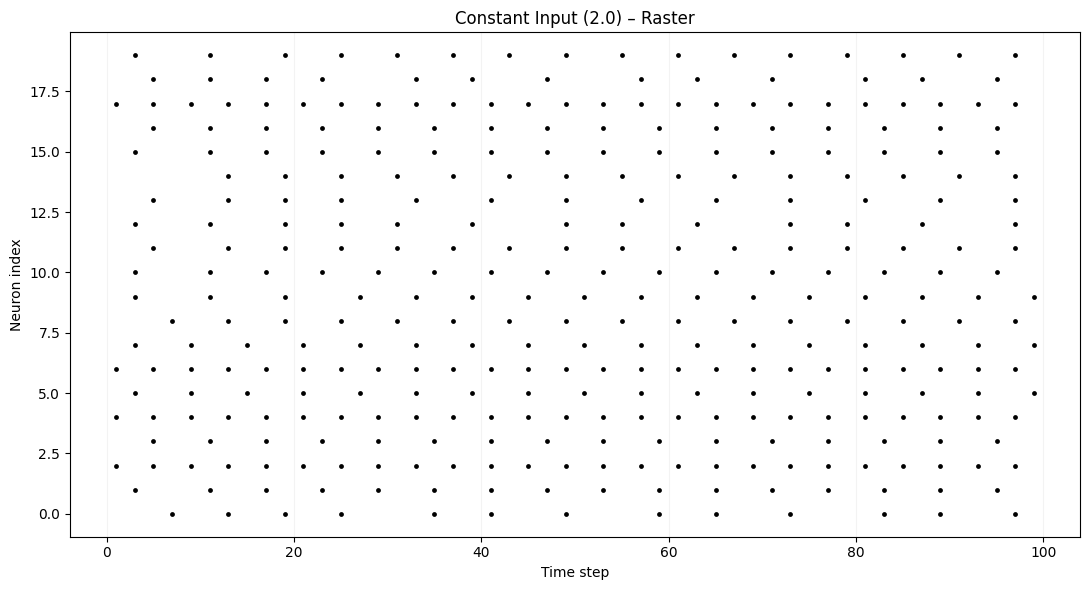

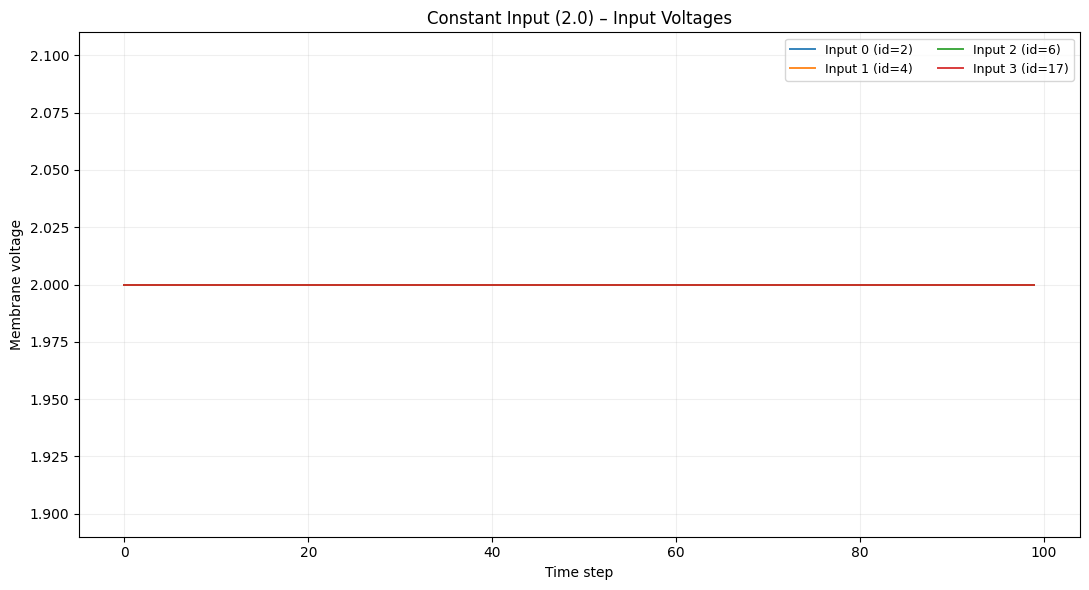


Running single strong pulse ...


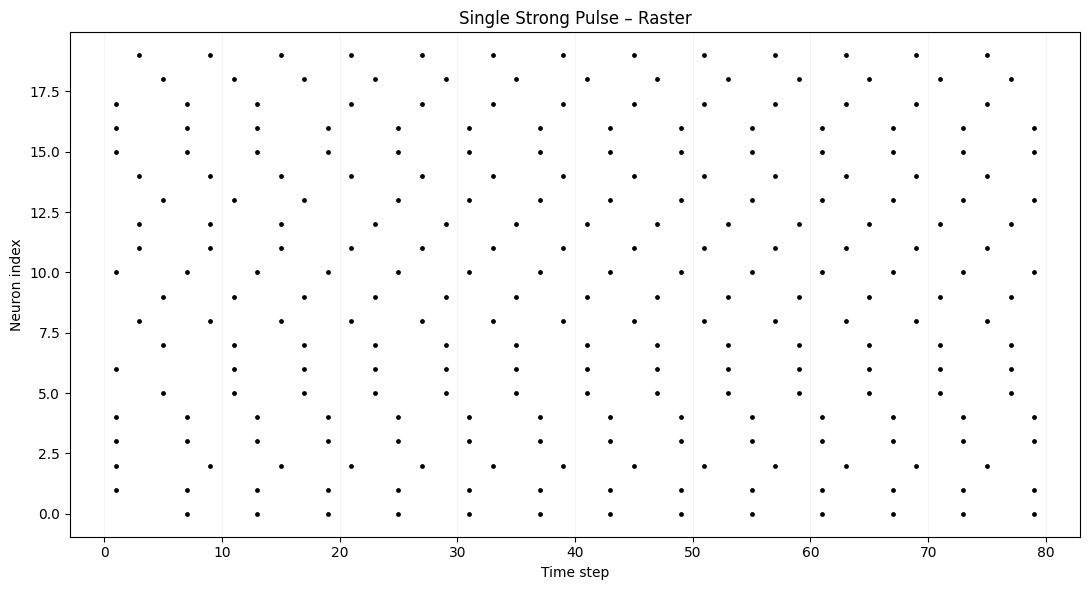

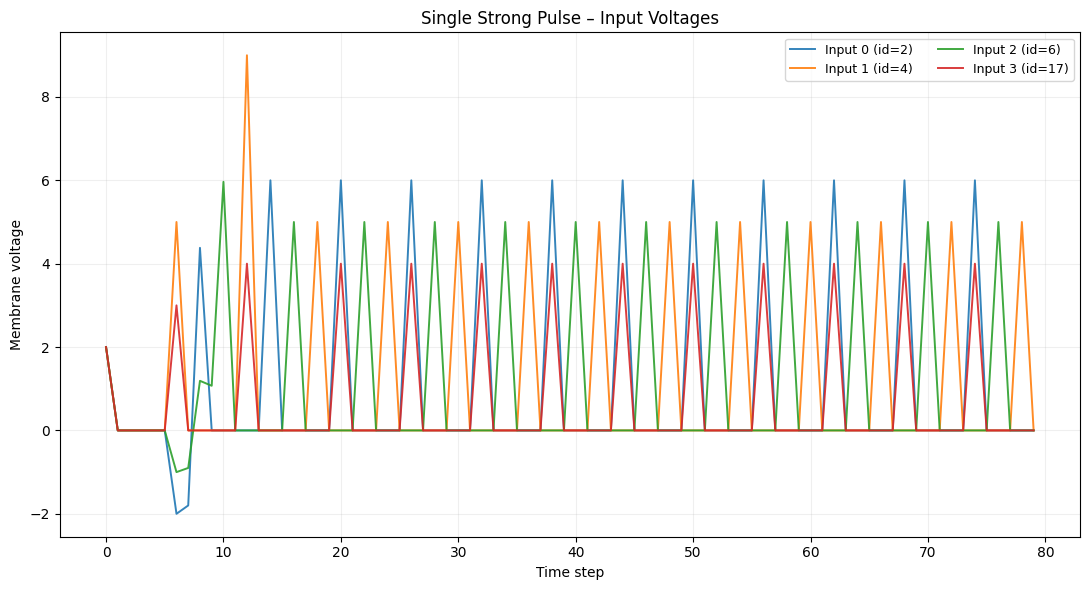


Running weak constant input (value = 0.8) ...


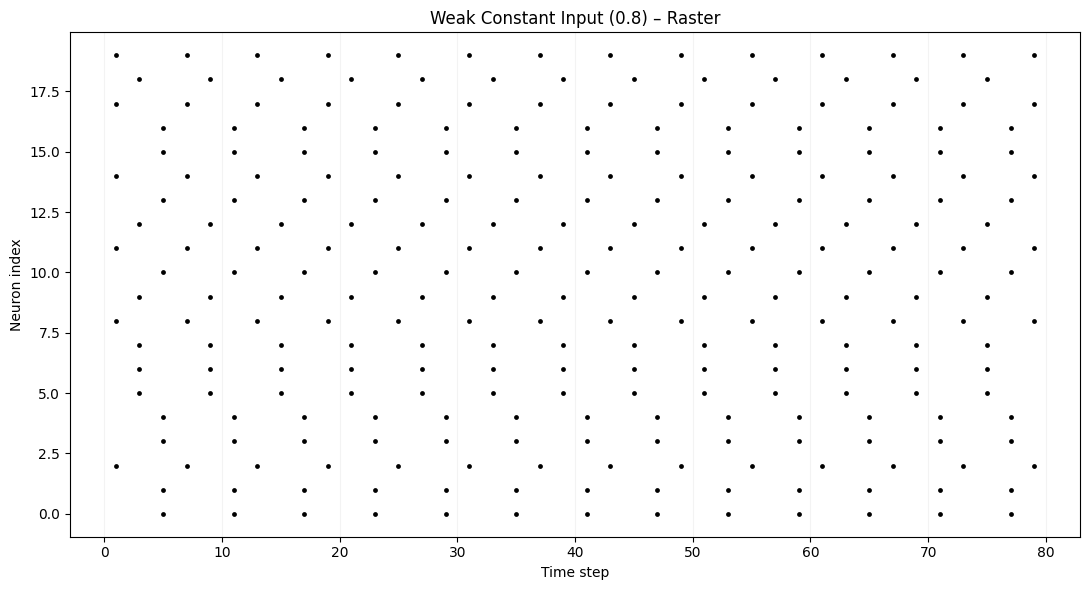

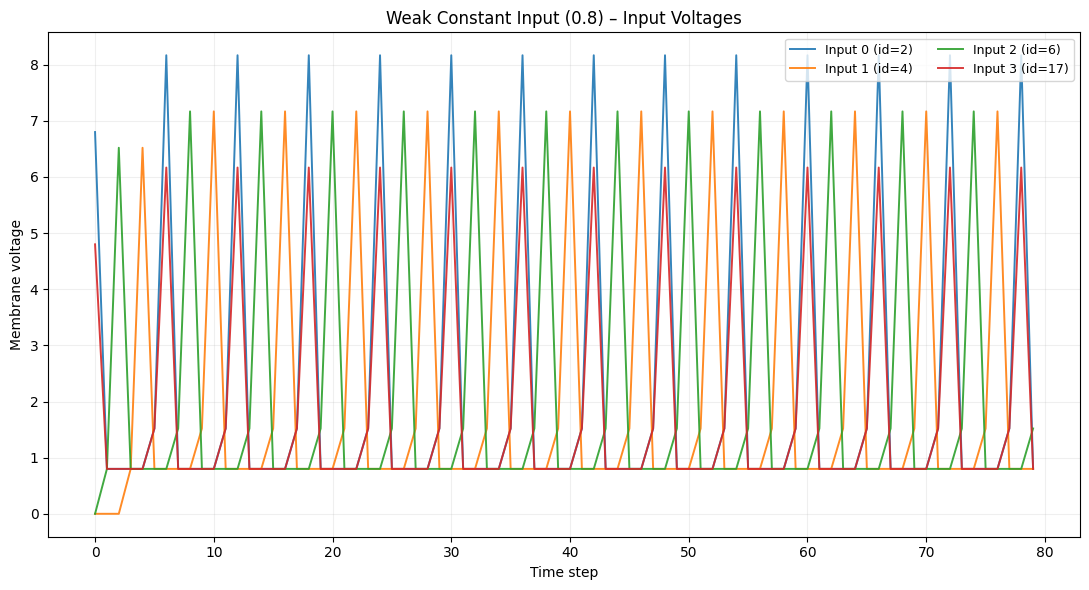

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────
#    Neuron parameters (used for ALL neurons)
# ────────────────────────────────────────────────
neuron_params = {
    "rest_voltage": 0.0,
    "threshold": 2.0,
    "time_constant": 10,           # membrane time constant (ms or steps)
    "refractoriness_time": 3       # absolute refractory period (steps)
}

# ────────────────────────────────────────────────
#          Instantiate the SNN network
# ────────────────────────────────────────────────
net = SNN(
    N=20,                  # total number of neurons
    exc_ratio=0.8,         # 80% excitatory → 4 inhibitory
    in_dim=4,              # 4 input neurons
    out_dim=3,             # 3 output neurons
    **neuron_params        # LIF parameters applied to all neurons
)

# Quick sanity check after creation
print("===== NETWORK CREATED =====")
print(f"Total neurons:      {net.N}")
print(f"Input neurons:      {len(net.in_interface)} (indices: {net.in_interface})")
print(f"Output neurons:     {len(net.out_interface)} (indices: {net.out_interface})")
print(f"Hidden neurons:     {net.N - len(net.in_interface) - len(net.out_interface)}")
print(f"Excitatory ratio:   {exc_ratio:.0%} → expected ~{int(net.N * 0.8)} exc, ~{int(net.N * 0.2)} inh")
print("Neuron params:", neuron_params)


# ────────────────────────────────────────────────
#     Combined simulation + recording function
# ────────────────────────────────────────────────
def run_snn_test_combined(
    net,
    T=80,
    input_mode="constant",
    input_value=1.0,
    pulse_time=10,
    seed=42
):
    """
    Runs SNN simulation and records:
      - spikes of ALL neurons
      - voltages of INPUT neurons only
    """
    np.random.seed(seed)
    
    spike_history   = np.zeros((T, net.N), dtype=int)
    voltage_history = np.zeros((T, len(net.in_interface)), dtype=float)
    
    for t in range(T):
        # Input generation
        if input_mode == "constant":
            input_data = np.ones(net.in_dim) * input_value
        elif input_mode == "pulse":
            input_data = np.zeros(net.in_dim)
            if t == pulse_time:
                input_data[:] = input_value
        elif input_mode == "random":
            input_data = np.random.randint(0, 2, size=net.in_dim).astype(float)
            # Optional: scale random spikes → input_data *= input_value
        else:
            raise ValueError(f"Unknown input_mode: {input_mode}")
        
        # Step network
        net.feed_forward(input_data)
        
        # Record spikes (all)
        for i in range(net.N):
            spike_history[t, i] = net.neurons[i].sigma
        
        # Record input voltages
        for k, idx in enumerate(net.in_interface):
            voltage_history[t, k] = net.neurons[idx].voltage
    
    return spike_history, voltage_history


# ────────────────────────────────────────────────
#               Plotting functions
# ────────────────────────────────────────────────
def plot_spike_raster(spike_history, title="Spike Raster Plot"):
    T, N = spike_history.shape
    fig, ax = plt.subplots(figsize=(11, 6))
    for n in range(N):
        times = np.where(spike_history[:, n] == 1)[0]
        ax.scatter(times, np.full_like(times, n), s=12, c='k', lw=0)
    ax.set(xlabel="Time step", ylabel="Neuron index", title=title)
    ax.grid(True, alpha=0.15, axis='x')
    plt.tight_layout()
    plt.show()


def plot_voltage_trace(voltage_history, in_interface, title="Input Neuron Voltage Evolution"):
    T, n_in = voltage_history.shape
    fig, ax = plt.subplots(figsize=(11, 6))
    time = np.arange(T)
    for i in range(n_in):
        neuron_id = in_interface[i]
        ax.plot(time, voltage_history[:, i],
                label=f"Input {i} (id={neuron_id})", lw=1.4, alpha=0.9)
    ax.set(xlabel="Time step", ylabel="Membrane voltage", title=title)
    ax.legend(loc='upper right', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()


# ────────────────────────────────────────────────
#            Run and visualize examples
# ────────────────────────────────────────────────

# Example A: Constant moderate input
print("\nRunning constant input (value = 2.0) ...")
spikes_c, volts_c = run_snn_test_combined(
    net, T=100,
    input_mode="constant",
    input_value=2.0,
    seed=123
)

plot_spike_raster(spikes_c, "Constant Input (2.0) – Raster")
plot_voltage_trace(volts_c, net.in_interface, "Constant Input (2.0) – Input Voltages")


# Example B: Strong single pulse
print("\nRunning single strong pulse ...")
spikes_p, volts_p = run_snn_test_combined(
    net, T=80,
    input_mode="pulse",
    input_value=4.0,       # strong → should cause input spikes
    pulse_time=12,
    seed=456
)

plot_spike_raster(spikes_p, "Single Strong Pulse – Raster")
plot_voltage_trace(volts_p, net.in_interface, "Single Strong Pulse – Input Voltages")


# Example C: Weak constant input (subthreshold?)
print("\nRunning weak constant input (value = 0.8) ...")
spikes_w, volts_w = run_snn_test_combined(
    net, T=80,
    input_mode="constant",
    input_value=0.8,
    seed=789
)

plot_spike_raster(spikes_w, "Weak Constant Input (0.8) – Raster")
plot_voltage_trace(volts_w, net.in_interface, "Weak Constant Input (0.8) – Input Voltages")

### Visualizing The Network

Descriminating input/output neurons in rectangles and put all other neurons in 3-D like space.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Rectangle

def plot_snn_graph_with_io_spring(net, max_edges=200, seed=0):
    rng = np.random.default_rng(seed)
    G = nx.DiGraph()
    
    # Add nodes
    for i in range(net.N):
        G.add_node(i)
    
    # Add edges (j → i)
    edges = np.argwhere(net.topology)
    if len(edges) > max_edges:
        edges = edges[rng.choice(len(edges), max_edges, replace=False)]
    for i, j in edges:
        G.add_edge(j, i)
    
    # ---- Initial positions ----
    pos_init = {}
    # Input neurons: left
    for k, n in enumerate(net.in_interface):
        pos_init[n] = np.array([-2.0, k])
    # Output neurons: right
    for k, n in enumerate(net.out_interface):
        pos_init[n] = np.array([2.0, k])
    # Other neurons: random spread
    for n in G.nodes():
        if n not in pos_init:
            pos_init[n] = rng.uniform(-1.0, 1.0, size=2)
    
    # ---- Spring layout with fixed nodes ----
    fixed_nodes = list(net.in_interface) + list(net.out_interface)
    pos = nx.spring_layout(
        G,
        pos=pos_init,
        fixed=fixed_nodes,
        seed=seed,
        k=1.8,          # repulsion distance (tune if needed)
        iterations=300
    )
    
    # ---- Colors ----
    node_colors = [
        "red" if net.if_excitatory[n] else "blue"
        for n in G.nodes()
    ]
    
    fig, ax = plt.subplots(figsize=(11, 9))
    
    # Draw network
    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=420,
        alpha=0.9,
        ax=ax
    )
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle="->",
        arrowsize=10,
        alpha=0.3,
        ax=ax
    )
    nx.draw_networkx_labels(
        G, pos,
        labels={n: str(n) for n in G.nodes()},
        font_size=9,
        ax=ax
    )
    
    # ───────────────────────────────────────────────
    #  Draw rectangle around INPUT nodes
    # ───────────────────────────────────────────────
    if len(net.in_interface) > 0:
        in_nodes_pos = np.array([pos[n] for n in net.in_interface])
        x_min_in, y_min_in = in_nodes_pos.min(axis=0)
        x_max_in, y_max_in = in_nodes_pos.max(axis=0)
        
        # Add some padding
        pad_x = 0.6
        pad_y = 0.5 if len(net.in_interface) > 1 else 0.8
        
        rect_in = Rectangle(
            (x_min_in - pad_x, y_min_in - pad_y),
            width=(x_max_in - x_min_in) + 2 * pad_x,
            height=(y_max_in - y_min_in) + 2 * pad_y,
            linewidth=1.8,
            edgecolor='darkgreen',
            facecolor='none',
            linestyle='--',
            alpha=0.7,
            label="Input layer"
        )
        ax.add_patch(rect_in)
    
    # ───────────────────────────────────────────────
    #  Draw rectangle around OUTPUT nodes
    # ───────────────────────────────────────────────
    if len(net.out_interface) > 0:
        out_nodes_pos = np.array([pos[n] for n in net.out_interface])
        x_min_out, y_min_out = out_nodes_pos.min(axis=0)
        x_max_out, y_max_out = out_nodes_pos.max(axis=0)
        
        pad_x = 0.6
        pad_y = 0.5 if len(net.out_interface) > 1 else 0.8
        
        rect_out = Rectangle(
            (x_min_out - pad_x, y_min_out - pad_y),
            width=(x_max_out - x_min_out) + 2 * pad_x,
            height=(y_max_out - y_min_out) + 2 * pad_y,
            linewidth=1.8,
            edgecolor='darkred',
            facecolor='none',
            linestyle='--',
            alpha=0.7,
            label="Output layer"
        )
        ax.add_patch(rect_out)
    
    # Final touches
    ax.set_title("SNN Connectivity (Spring Layout with I/O groups)\nRed = Excitatory | Blue = Inhibitory")
    ax.axis("off")
    
    # Optional: show legend for the rectangles
    ax.legend(handles=[rect_in, rect_out], loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

#### Calling the plot function

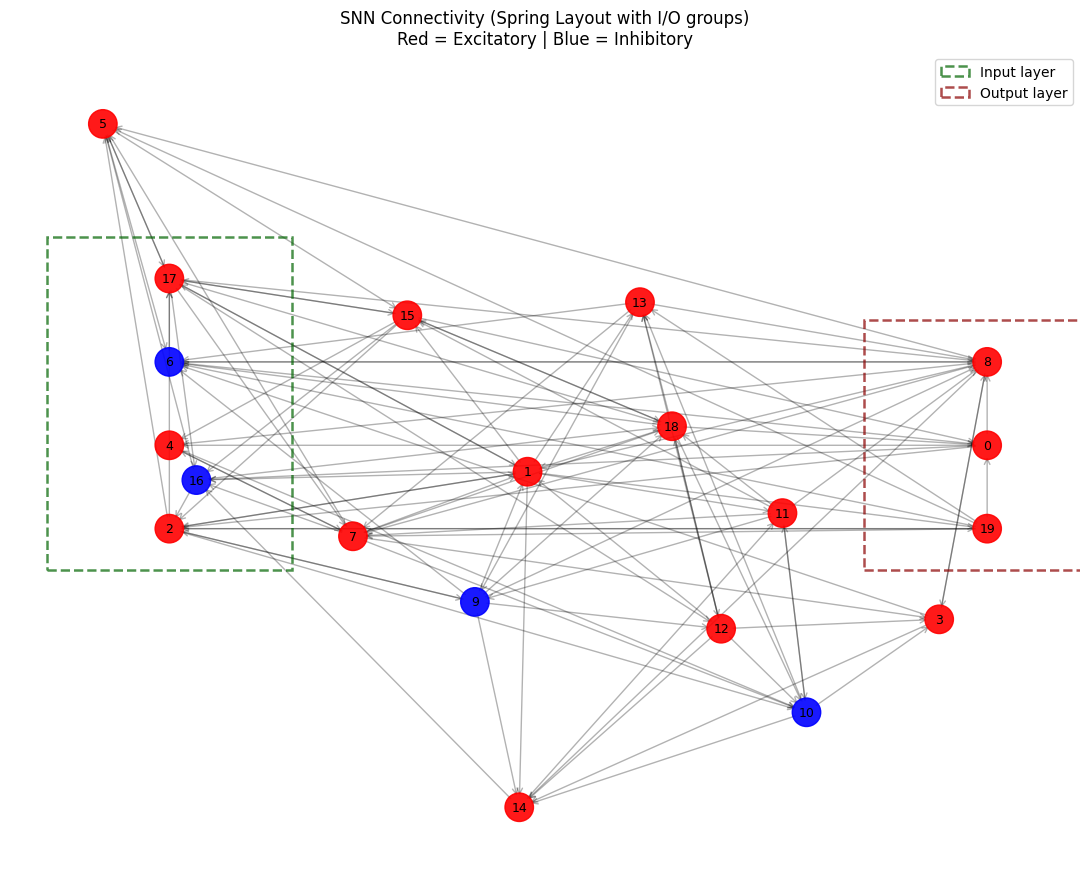

In [69]:
plot_snn_graph_with_io_spring(net, max_edges=300)

### To Do

- problem of firing pattern in network to be inspected

-  the connection init mechanism to be edited

-  input/output layers from the rest to be seperated

-  voltage debugger to be edited , so that voltage after threshold can be seen

- Izhikevich Neuron models to be tested.